## Use CNN to extract features from flow images

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

cnn_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

def prepare_flow_image(flow_image_path):
    flow_image = cv2.imread(flow_image_path)

    # Resize to match CNN input size
    flow_image_resized = cv2.resize(flow_image, (128, 128))

    # Convert to array
    image_array = img_to_array(flow_image_resized)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_input(image_array)  # Normalize

    return image_array

# flow images directory
flow_images_dir = '/content/drive/MyDrive/5243/Project2/downsampled_data/Masks/flows'
flow_features = []

# Extract features from each flow image
for filename in os.listdir(flow_images_dir):
    if filename.endswith('.tif'):
        flow_image_path = os.path.join(flow_images_dir, filename)
        flow_image_prepared = prepare_flow_image(flow_image_path)
        features = cnn_model.predict(flow_image_prepared)
        flow_features.append(features.flatten())

flow_features = np.array(flow_features)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1

## RandomForest

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import re

# Load metadata
metadata_path = '/content/drive/MyDrive/5243/Project2/metadata_BR00116991.csv'
metadata = pd.read_csv(metadata_path)

# Extract identifiers from flow image filenames
flow_files = [f for f in os.listdir(flow_images_dir) if f.startswith('FLOWS_') and f.endswith('.tif')]
flow_identifiers = [re.search(r'FLOWS_(r\d+c\d+f\d+)_', f).group(1) for f in flow_files]

# DataFrame for flow images with identifiers for matching
flow_df = pd.DataFrame({
    'FlowFile': flow_files,
    'Identifier': flow_identifiers
})

# Extract identifiers from metadata 'FileName_OrigRNA' column
metadata['Identifier'] = metadata['FileName_OrigRNA'].apply(lambda x: re.search(r'(r\d+c\d+f\d+)', x).group(1))

# Filter metadata to include only rows with matching identifiers in flow images
metadata_filtered = metadata[metadata['Identifier'].isin(flow_df['Identifier'])]

# Merge metadata with flow DataFrame based on the Identifier
aligned_df = pd.merge(flow_df, metadata_filtered, on='Identifier')

# column for drug treatments
labels = aligned_df['Metadata_pert_iname'].values
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(flow_features, labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Accuracy: 0.18989547038327526
Classification Report:
                                          precision    recall  f1-score   support

                              1-octanol       0.00      0.00      0.00         2
                    2,5-furandimethanol       0.00      0.00      0.00         1
                                 4-CMTB       0.00      0.00      0.00         1
                      4-methylhistamine       0.00      0.00      0.00         6
                 7-hydroxystaurosporine       0.00      0.00      0.00         1
                                A205804       0.00      0.00      0.00         1
                                 AC-710       0.00      0.00      0.00         2
                                   AK-7       0.00      0.00      0.00         3
                                 ANR-94       0.00      0.00      0.00         2
                                  AR-12       0.25      1.00      0.40         1
                                AVL-292

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Doing classification directly will obtain a pretty low accuracy. This is because we have very imbalanced datasets with each drug treatment. So, I choose to divide the drug treatment to simply two categories: DMSO and non-DMSO, to ensure each treatment has enough dataset for training and testing purpose.

In [3]:
aligned_df['Metadata_pert_iname'].value_counts()

,count
Metadata_pert_iname,
DMSO,509
thiostrepton,18
lonafarnib,18
GSK2110183,18
CYT-997,18
...,...
KG-5,9
racecadotril,9
methoxsalen,9


In [4]:
from collections import Counter

# Convert labels to binary classes: 'DMSO' and 'non-DMSO'
binary_labels = ['DMSO' if label == 'DMSO' else 'non-DMSO' for label in labels]

# See number of data in each group
print("Binary label distribution:", Counter(binary_labels))

X_train, X_test, y_train, y_test = train_test_split(flow_features, binary_labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Binary Classification Accuracy (DMSO vs. non-DMSO):", accuracy_score(y_test, y_pred))
print("Binary Classification Report:\n", classification_report(y_test, y_pred))

Binary label distribution: Counter({'non-DMSO': 2358, 'DMSO': 509})
Binary Classification Accuracy (DMSO vs. non-DMSO): 0.8153310104529616
Binary Classification Report:
               precision    recall  f1-score   support

        DMSO       0.00      0.00      0.00       106
    non-DMSO       0.82      1.00      0.90       468

    accuracy                           0.82       574
   macro avg       0.41      0.50      0.45       574
weighted avg       0.66      0.82      0.73       574



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


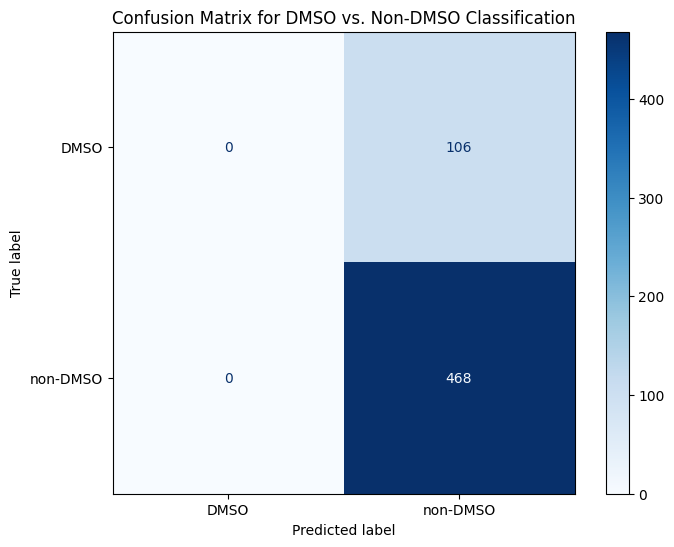

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["DMSO", "non-DMSO"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["DMSO", "non-DMSO"])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix for DMSO vs. Non-DMSO Classification")
plt.show()

In [8]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


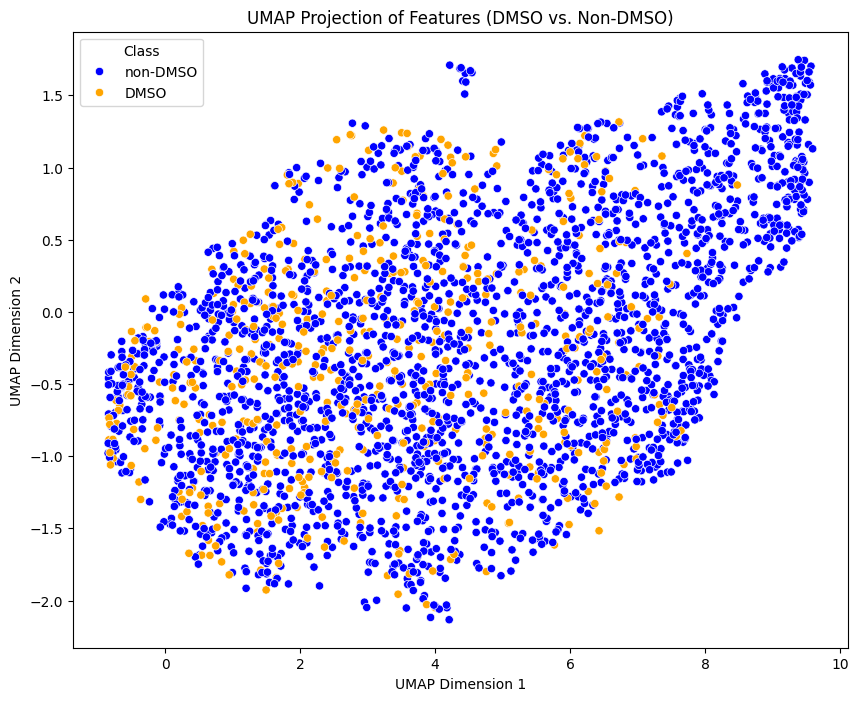

In [9]:
import umap
import seaborn as sns

# Perform UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = reducer.fit_transform(flow_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=binary_labels, palette=['blue', 'orange'])
plt.title("UMAP Projection of Features (DMSO vs. Non-DMSO)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Class")
plt.show()

Though this method obtains a really high accuracy, DMSO were all misclassified. So, it might not be optimal. Try using a different classification model to see if it works better.

## SVM with a radial basis function (RBF) kernel

SVM Classification Accuracy (DMSO vs. non-DMSO): 0.632404181184669
SVM Classification Report:
               precision    recall  f1-score   support

        DMSO       0.24      0.46      0.32       106
    non-DMSO       0.85      0.67      0.75       468

    accuracy                           0.63       574
   macro avg       0.54      0.57      0.53       574
weighted avg       0.73      0.63      0.67       574



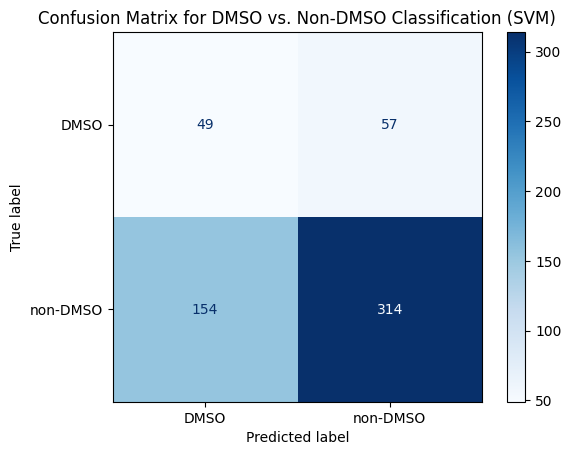

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(flow_features, binary_labels, test_size=0.2, random_state=42)
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("SVM Classification Accuracy (DMSO vs. non-DMSO):", accuracy_score(y_test, y_pred))
print("SVM Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for DMSO vs. Non-DMSO Classification (SVM)")
plt.show()

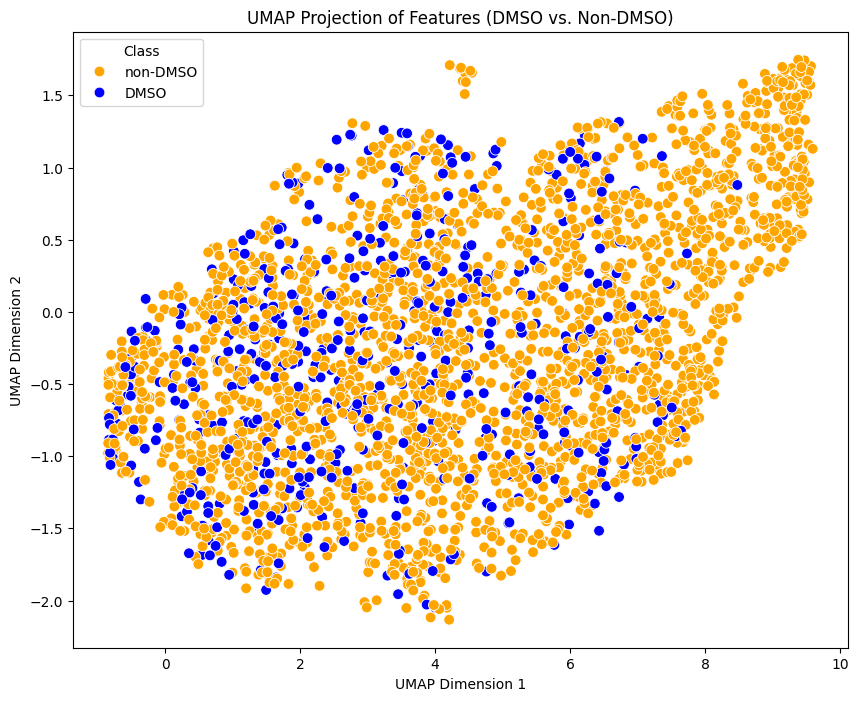

In [10]:
# UMAP with color-coded classes
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=binary_labels, palette=['orange', 'blue'], s=60)
plt.title("UMAP Projection of Features (DMSO vs. Non-DMSO)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Class")
plt.show()